## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [62]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sanjayakumarsahoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjayakumarsahoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [63]:
# Opening JSON file 
file = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(file)
compalints_df = pd.json_normalize(data)

## Data preparation

In [64]:
# Inspect the dataframe to understand the given data.
compalints_df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [65]:
#print the column names
print(compalints_df.info())
print(compalints_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [66]:
# remove "_" and _source" from columns
new_column_names = {}
for col in compalints_df.columns:
    new_column_names[col] = re.sub("^_", "", col).replace("source.", "")
compalints_df.rename(columns = new_column_names, inplace = True)
compalints_df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [67]:
# Assign new column names
# and renaming the column names
compalints_df = compalints_df.rename(columns={'complaint_what_happened': 'complaint_text', 'product': 'category','sub_product': 'sub_category'})
compalints_df[["complaint_text", "category", "sub_category"]]

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card
...,...,...,...
78308,,Checking or savings account,Checking account
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card


In [68]:
# print shape and size of dataset
compalints_df.shape

(78313, 22)

In [69]:
#Assign nan in place of blanks in the complaints column
compalints_df.complaint_text.replace(r'', np.nan, regex=True, inplace=True)

In [70]:
compalints_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_category,timely,complaint_text,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [71]:
print(compalints_df.complaint_text.isnull().sum())
print(len(compalints_df[compalints_df['complaint_text']=='']))

57241
0


In [72]:
#Remove all rows where complaints column is nan
compalints_df = compalints_df[compalints_df.complaint_text.notna()]
print('After removing nan in complaints column, the remaining rows:', len(compalints_df))

After removing nan in complaints column, the remaining rows: 21072


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [73]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(sentence):
    sentence = sentence.lower()  # Make the text lowercase
    sentence = re.sub('\[.*\]','', sentence).strip() # Remove text in square brackets
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    sentence = re.sub('\S*\d\S*\s*','', sentence).strip()  # Remove words containing numbers
    return sentence.strip()

In [74]:
# Write your function here to clean the text and remove all the unnecessary elements.
compalints_df.complaint_text = compalints_df.complaint_text.apply(lambda sentence: clean_text(sentence))
compalints_df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [75]:
compalints_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_category,timely,complaint_text,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told b...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided


In [76]:
#Write your function to Lemmatize the texts
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_english = stopwords.words("english")
def lemmatizer(text):
    tokens = word_tokenize(text)
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in  stopwords_english ]
    return ' '.join(lemmatized)

In [77]:
compalints_df['lemma'] =  compalints_df.complaint_text.apply(lambda x: lemmatizer(x))
compalints_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_category,timely,complaint_text,sub_issue,consumer_consent_provided,lemma
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning name xxxx xxxx appreciate could h...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told b...,Problem with rewards from credit card,Consent provided,upgraded xxxx xxxx card told agent upgrade ann...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided,chase card reported however fraudulent applica...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i...,Information belongs to someone else,Consent provided,trying book xxxx xxxx ticket came across offer...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided,grand son give check deposit chase account fun...


In [78]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = compalints_df[['complaint_text','lemma']]
df_clean.head()

,complaint_text,lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket i...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...


In [79]:
df_clean

,complaint_text,lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket i...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...


In [80]:
#Write your function to extract the POS tags 
def pos_tag(text):
  # write your code here
  doc = nlp(text)
  sent = [token.text for token in doc if token.tag_ == 'NN']
  return ' '.join(sent)


# df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean['complaint_POS_removed'] =  df_clean.lemma.apply(lambda x: pos_tag(x))
df_clean.head()

/var/folders/2m/1yk16fzs6tj09dg30vltz2340000gn/T/ipykernel_7991/498059209.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...


In [81]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




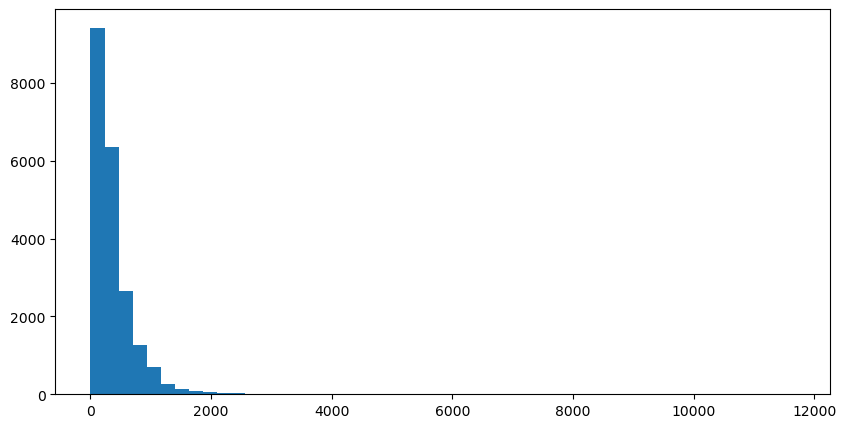

In [82]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,5))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [83]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud

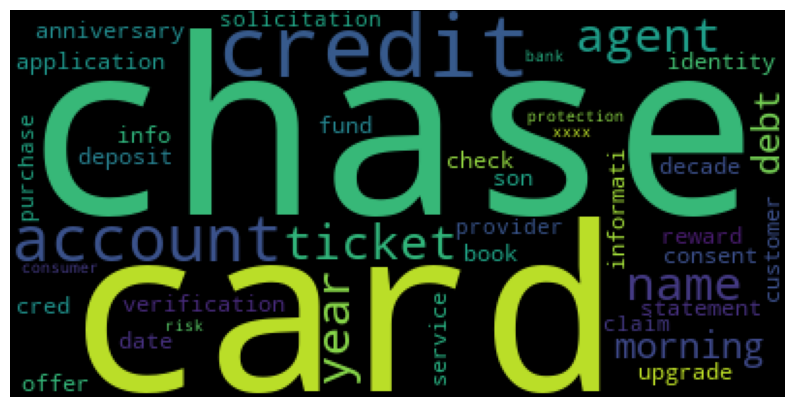

In [84]:
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_english,max_words=40).generate(str(df_clean.complaint_POS_removed))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [85]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.shape

/var/folders/2m/1yk16fzs6tj09dg30vltz2340000gn/T/ipykernel_7991/923498956.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [86]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [87]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean, ngram=1, top=30)

In [88]:
#Print the top 10 words in the unigram frequency
top_30_unigrams[:10]

[('chase', 53873),
 ('account', 42391),
 ('credit', 32531),
 ('card', 29868),
 ('xxxx', 21730),
 ('payment', 21085),
 ('bank', 17958),
 ('time', 15922),
 ('day', 12843),
 ('charge', 11922)]

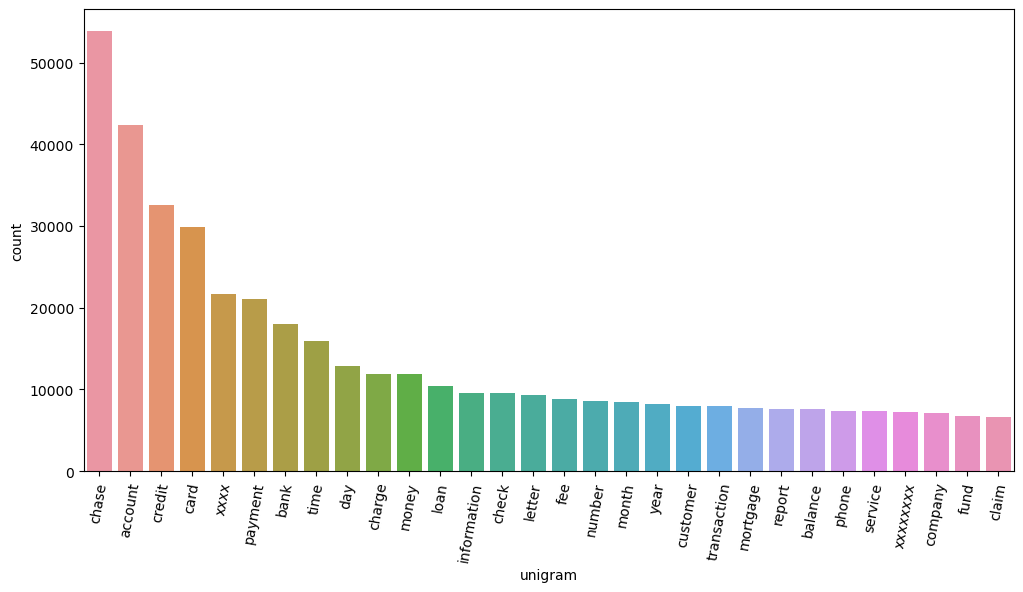

In [89]:
# plot unigram vs count
plot_df_unigrams = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=plot_df_unigrams['unigram'], y=plot_df_unigrams['count'])
plt.xticks(rotation = 80)
plt.show()

In [90]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean, ngram=2, top=30)

In [91]:
#Print the top 10 words in the bigram frequency
top_30_bigrams[:10]

[('credit card', 12760),
 ('credit report', 3809),
 ('chase credit', 3239),
 ('customer service', 2924),
 ('account chase', 2887),
 ('chase bank', 2595),
 ('chase account', 2455),
 ('account account', 2427),
 ('debit card', 1916),
 ('bank account', 1862)]

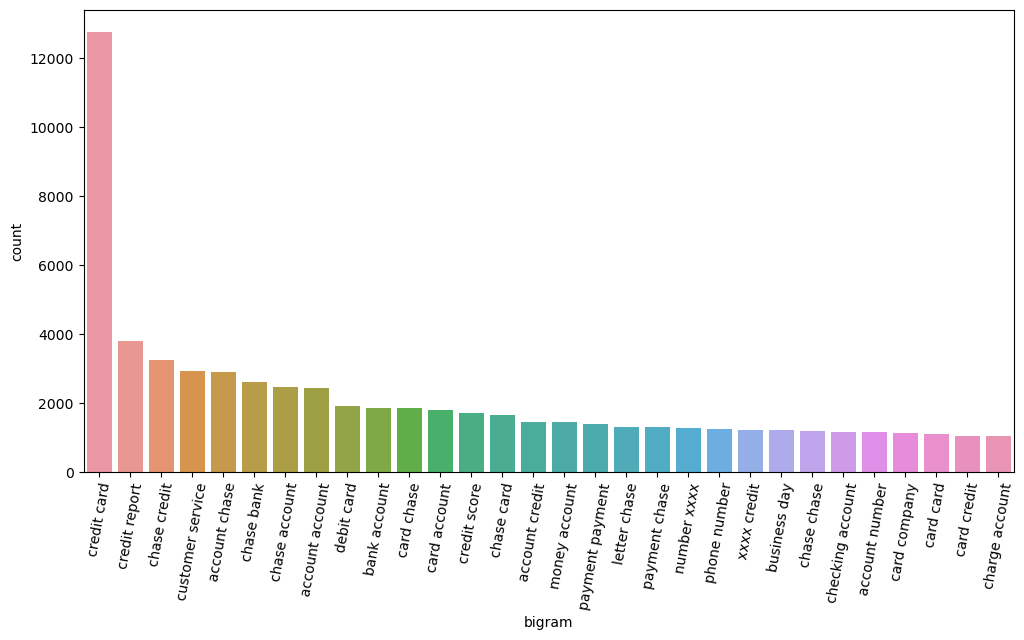

In [92]:
# plot bigram vs count
plot_df_bigram = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=plot_df_bigram['bigram'], y=plot_df_bigram['count'])
plt.xticks(rotation = 80)
plt.show()

In [93]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean, ngram=3, top=30)

In [94]:
#Print the top 10 words in the trigram frequency
top_30_trigrams[:10]

[('chase credit card', 2253),
 ('credit card account', 1147),
 ('credit card company', 986),
 ('credit card chase', 861),
 ('xxxx credit card', 612),
 ('credit card credit', 513),
 ('inquiry credit report', 495),
 ('chase customer service', 424),
 ('card credit card', 409),
 ('account credit card', 406)]

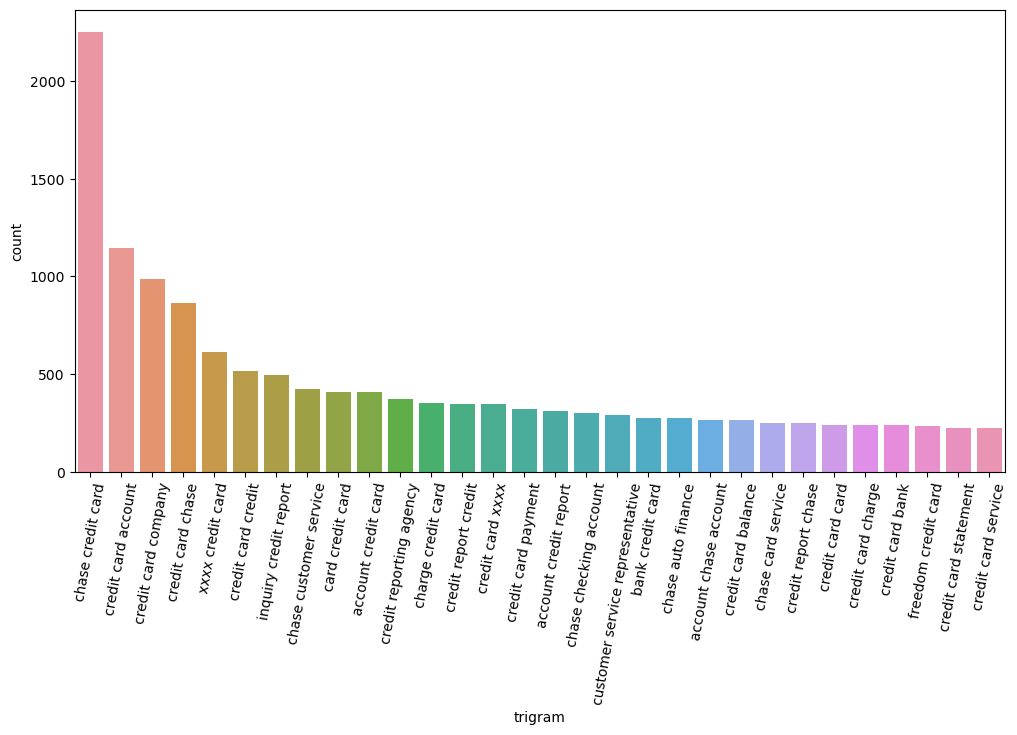

In [95]:
# plot trigram vs count
plot_df_trigram = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=plot_df_trigram['trigram'], y=plot_df_trigram['count'])
plt.xticks(rotation = 80)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [96]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

/var/folders/2m/1yk16fzs6tj09dg30vltz2340000gn/T/ipykernel_7991/619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
#All masked texts has been removed
df_clean.shape

(21072, 4)

In [98]:
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

In [99]:
df_clean.head()

,complaint_text,lemma,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket i...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [100]:
#Write your code here to initialise the TfidfVectorizer 
tf_idf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [101]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = tf_idf.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [102]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [103]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [104]:
# nmf_model.fit(dtm)
# len(tfidf.get_feature_names())
W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [105]:
#Print the Top15 words for each of the topics
words = np.array(tf_idf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,chase,fund,deposit,day,branch,transaction,number,claim,fee,business,customer
Topic 2,card,charge,chase,credit,dispute,purchase,service,transaction,fraud,balance,fee,merchant,time,company,customer
Topic 3,payment,balance,fee,month,statement,day,date,chase,time,credit,auto,pay,year,mortgage,account
Topic 4,credit,report,inquiry,account,score,debt,company,reporting,card,bureau,information,identity,application,theft,letter
Topic 5,loan,mortgage,chase,modification,home,property,year,letter,time,document,rate,foreclosure,sale,information,debt


In [106]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.02,0.00,0.01,0.02,0.03,4
Doc1,0.01,0.01,0.00,0.00,0.00,0
Doc2,0.00,0.03,0.00,0.03,0.00,1
Doc3,0.02,0.03,0.00,0.05,0.02,3
Doc4,0.07,0.00,0.00,0.00,0.01,0


In [107]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = significant_topic

In [108]:
df_clean.shape

(21072, 4)

In [109]:
df_clean.head()

,complaint_text,lemma,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,0
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,card application identity consent service cred...,1
11,on while trying to book a xxxx xxxx ticket i...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,3
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,0


In [110]:
#Print the first 5 Complaint for each of the Topics
df_clean_5 = df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_text,lemma,Complaint_clean,Topic
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,0
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,account debit card branch customer service rep...,0
21,on xxxx i made a payment to an online retailer...,xxxx made payment online retailer using chase ...,payment retailer chase pay website scam websit...,0
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto,0
32,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,card catering order brother funeral amount cha...,1
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,card application identity consent service cred...,1
50,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen company time share company nothing cre...,1
45,i made a purchase with xxxx xxxx xxxx on in th...,made purchase xxxx xxxx xxxx amount charged tw...,purchase amount transaction dispute case chas...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,seat table chair debit card bank visa claim fu...,1


In [111]:
df_clean.shape

(21072, 4)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [112]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [113]:
df_clean

,complaint_text,lemma,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,card application identity consent service cred...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,Bank Account services
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,Credit card or prepaid card
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,risk consumer bank chase year trust mobile ba...,Bank Account services
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit chase credit card chase freedom problem...,Others


<Axes: xlabel='Topic', ylabel='count'>

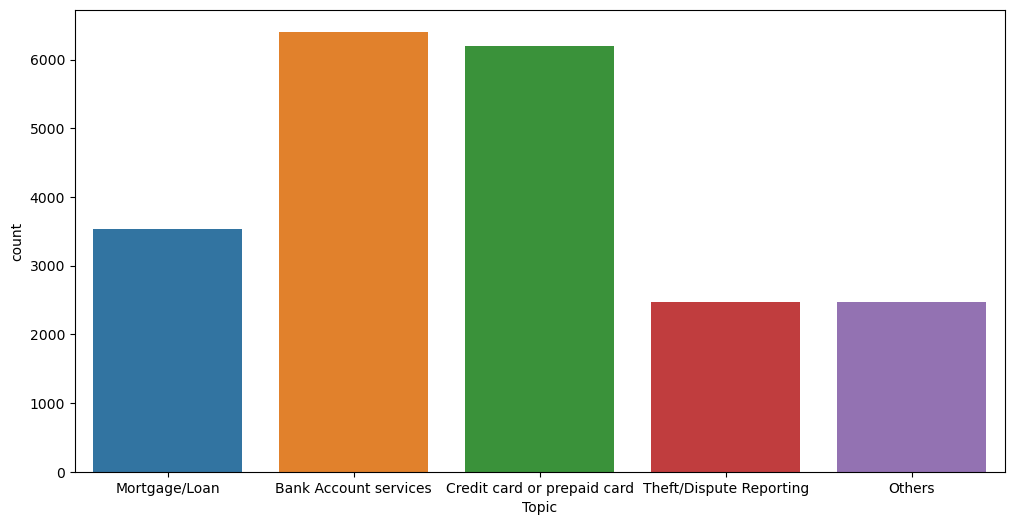

In [114]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic', data=df_clean)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [118]:
#Create the dictionary again of Topic names and Topics
topic_mappings = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}

In [120]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_text','Topic']]

In [122]:
training_data['Topic'] = training_data['Topic'].map(topic_mappings)

/var/folders/2m/1yk16fzs6tj09dg30vltz2340000gn/T/ipykernel_7991/3781134089.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [123]:
training_data

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i...,3
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,1
78310,i am not familiar with xxxx pay and did not un...,0
78311,i have had flawless credit for yrs ive had cha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [140]:
#Write your code to get the Vector count
X = training_data.complaint_text
y = training_data.Topic

count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [141]:
# Saving Word Vector on disk for later usage
import pickle
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [ ]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [142]:
# Save tf-idf on disk for later usage
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [145]:
# train test split
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 33584)
y_train Shape: (15804,)
X_test Shape: (5268, 33584)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# Write your code here to build any 3 models and evaluate them using the required metrics

In [162]:
# creating a function to evaluate models
def model_eval(y_test, y_pred, model_name):
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    #plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

### Model 1 - Logistic Regression

In [155]:
# Import required library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [151]:
model_name = 'logistic-regression'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [152]:
# hyperparameter tuning
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [153]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, penalty='l1', solver='saga')
lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [156]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9403161158048107

CLASSIFICATION REPORT for logistic-regression

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1587
Credit card or prepaid card       0.94      0.95      0.94      1587
                     Others       0.93      0.94      0.94       618
    Theft/Dispute Reporting       0.94      0.90      0.92       605
              Mortgage/Loan       0.95      0.92      0.93       871

                   accuracy                           0.94      5268
                  macro avg       0.94      0.93      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



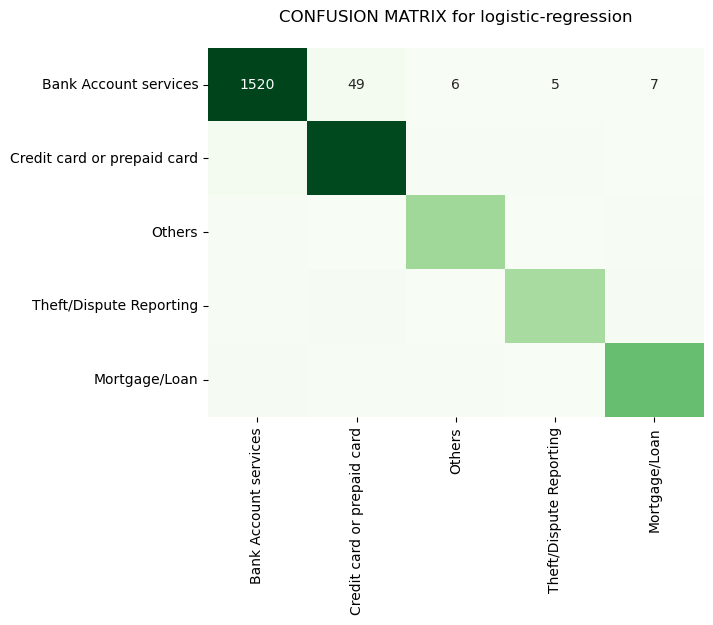

In [163]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [160]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summary

,Model,F1 Score
0,Logistic Regression,0.94


### Model 2 - Decision Tree

In [164]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [165]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [166]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10}


In [167]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [168]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.8219589616189299

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.87      0.83      1587
Credit card or prepaid card       0.85      0.81      0.83      1587
                     Others       0.80      0.81      0.81       618
    Theft/Dispute Reporting       0.79      0.76      0.78       605
              Mortgage/Loan       0.85      0.80      0.83       871

                   accuracy                           0.82      5268
                  macro avg       0.82      0.81      0.82      5268
               weighted avg       0.82      0.82      0.82      5268



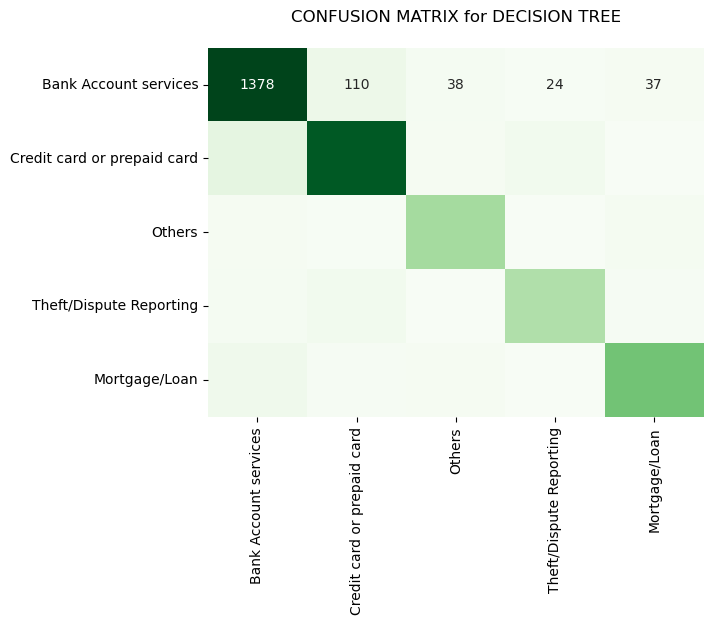

In [169]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

In [170]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.82
